# GradientTape and Automatic Differentiation

In [31]:
import tensorflow as tf
from numpy import pi
from tensorflow.math import sin, cos, sqrt

In [36]:
x = tf.Variable(3.0)

f = lambda x: x**2

with tf.GradientTape() as tape:
    y = f(x)
    dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


In [30]:
x = tf.Variable([pi/4, 3])

f = lambda x: sin(x[0]) + x[0]*x[1]

bool(f(x) == sqrt(2.0)/2 + 3*pi/4)

True

In [37]:
with tf.GradientTape() as tape:
    y = f(x)
    dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


## Some math

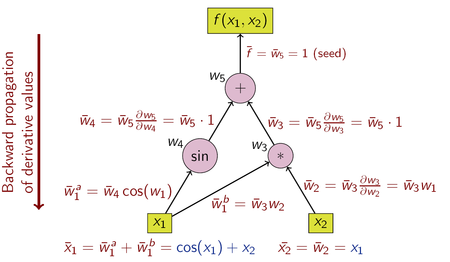

Some definitions:

$
\begin{align*}
\bar{w} &:= \frac{\partial y}{\partial w}\\
w_1 &:= x_1\\
w_2 &:= x_2\\
w_3 &:= w_1 \cdot w_2\\
w_4 &:= sin(w_1)\\
w_5 &:= y = w_3 + w_4
\end{align*}
$


Tensorflow builds this graph as computations are carried out in the `GradientTape` context, and can then calculate the gradients of all the variables using the chain rule:

$
\begin{align*}
\bar{w_5} &:= 1 \quad \text{(by definition)}\\
\bar{w_4} &= \bar{w_5}\frac{\partial{w_5}}{\partial{w_4}} = 1 \cdot 1\\
\bar{w_3} &= \bar{w_5}\frac{\partial{w_5}}{\partial{w_3}} = 1 \cdot 1\\
\bar{w_2} &= \bar{w_3}\frac{\partial{w_3}}{\partial{w_2}} = 1 \cdot w_1\\
\bar{w_1} &= \bar{w_4}\frac{\partial{w_4}}{\partial{w_1}} + \bar{w_3}\frac{\partial{w_3}}{\partial{w_1}} = 1 \cdot \cos(w_1) + 1 \cdot w_2\\
\bar{x}|_{x=[\pi/4, 3]} &= [\cos(\pi/4 + 3), \pi/4]
\end{align*}
$

In [26]:
all(dy_dx == [cos(pi/4) + 3, pi/4])

True

## Jacobians

In [80]:
x = tf.Variable([2.0, 3.0])

f = lambda x: tf.convert_to_tensor([x[0] + x[1], x[0]*x[1]])


with tf.GradientTape() as tape:
    y = f(x)
    jac = tape.jacobian(y, x)
print(jac)

tf.Tensor(
[[1. 1.]
 [3. 2.]], shape=(2, 2), dtype=float32)


# Writing a modular Deep Q Learning `keras.Model`

In [83]:
from tensorflow import keras
from tensorflow.math import argmax
import random

In its current form, this model has a hard-coded network layout. You can edit in the model definition, or factor it out as I briefly described in class.

In [158]:
class QLearner (keras.Model):
    def __init__(
            self, 
            state_dim, 
            action_dim, 
            hidden_units=24, 
            exploration_prob=0.1,
            discount_rate=0.9,
            name='qlearner', 
            **kwargs
        ):
        super().__init__(**kwargs)
        self.exploration_prob = exploration_prob
        self.discount_rate = discount_rate
        self.input_dim = state_dim
        self.action_dim = action_dim
        self.hidden = keras.layers.Dense(hidden_units, activation='relu')
        self.out = keras.layers.Dense(action_dim, activation='linear')
    
    def call(self, inputs):
        h = self.hidden(inputs)
        return self.out(h)
    
    def choose_action(self, q):
        if random.random() < self.exploration_prob:
            return random.randrange(self.action_dim)
        else:
            return argmax(q)
        
    def select_best_move(self, world):
        state = tf.convert_to_tensor([world.state])
        q = self(state, training=False)[0]
        return argmax(q)
    
    def train_step(self, world):
        state = tf.convert_to_tensor([world.state])
        
        with tf.GradientTape() as tape:
            q = self(state, training=True)[0]
            action = self.choose_action(y)
            reward, next_state = world.act(action)
            next_state = tf.convert_to_tensor([next_state])
            q_observed = q[action]
            
            
            # calculate estimate of q value based on reward and q of best action in next state
            if world.terminal():
                best_next_q_value = 0
            else:
                next_q_values = tf.stop_gradient(self(next_state))[0] # No gradient computation
                best_next_action = argmax(next_q_values)
                best_next_q_value = next_q_values[best_next_action]
            
            q_estimate = reward + self.discount_rate * best_next_q_value
            #loss can be factored out--use model.compile(loss=keras.losses{DESIRED_LOSS_FUNCTION}) and call it using self.loss_function
            loss = (q_observed - q_estimate)**2
        
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

If you can formulate your problem as a `world` object that supports accessing its state as a python list, an `act` method that returns a reward and the new state after executing an action with given index, and a `terminal` method that returns if the current state is final, you can train this model on your problem

In [139]:
class MultiArmedBandit:
    def __init__(self):
        self.action_dim = 4
        self.bandits = [0.9, 1.2, 0.7, 1.0]
        self.state = [0.0] * 5
    
    def terminal(self):
        return self.state[-1] >= 1
    
    def act(self, action):
        reward = tf.random.normal([1], mean=self.bandits[action], stddev=1)[0].numpy()
        reward = reward * (argmax(self.state).numpy() + 1)
        self.state = [1.0 if i == action else 0.0 for i in range(self.action_dim)] + [self.state[self.action_dim] + 1/6 + 1/1000]
        return reward, self.state
        

In [168]:
games_to_train = 5000
model = QLearner(5, 4, exploration_prob=0.05)
model.compile(optimizer="adam")
for i in range(games_to_train):
    world = MultiArmedBandit()
    while not world.terminal():
        model.train_step(world)
    if i % 1000 == 0:
        print(i, 'games')
        #when calling the model with a state directly, you must promote the state's dimension because tf expects batches
        #you could override the `predict` method of the model to abstract this away
        print('state 0', model(tf.convert_to_tensor([[1,0,0,0,0]])).numpy())
        print('state 3', model(tf.convert_to_tensor([[0,0,0,1,0]])).numpy())

0 games
state 0 [[-0.23035078  0.13247749  0.09375991  0.05241053]]
state 3 [[-0.21479599 -0.17125915 -0.2387585   0.11107624]]
1000 games
state 0 [[4.7072353 9.547577  4.7100997 5.568705 ]]
state 3 [[ 6.189749  12.3255205  5.0733714  7.5268435]]
2000 games
state 0 [[ 9.800052 13.843966 10.091611 10.820382]]
state 3 [[11.841204 16.67495  11.012055 13.153909]]
3000 games
state 0 [[10.472055 14.605456 12.623755 13.14423 ]]
state 3 [[12.826076 17.978754 14.059893 15.971729]]
4000 games
state 0 [[13.254826  16.604494  15.4101715 16.208334 ]]
state 3 [[15.115817 18.807869 16.365416 18.250547]]


In [159]:
class MultiArmedBandit2:
    def __init__(self):
        self.action_dim = 4
        self.meanmatrix = [[1, 3, 2, 4], 
                           [0, 1, 4, 3], 
                           [5, 0, 0, 0], 
                           [1, 3, 1, 3]]
        self.state = [1.0] + [0.0] * 4
    
    def terminal(self):
        return self.state[-1] >= 1
    
    def get_reward(self, action):
        state = self.state.index(1)
        mean = self.meanmatrix[state][action]
        return tf.random.normal([1], mean=mean, stddev=1)[0].numpy()
        
    def act(self, action):
        reward = self.get_reward(action)
        self.state = [1.0 if i == action else 0.0 for i in range(self.action_dim)] + [self.state[self.action_dim] + 1/12 + 1/1000]
        return reward, self.state

In [169]:
games_to_train = 5000
model = QLearner(5, 4, exploration_prob=0.1, discount_rate=0.99)
model.compile(optimizer="adam")
for i in range(games_to_train):
    world = MultiArmedBandit2()
    while not world.terminal():
        model.train_step(world)
    if i % 1000 == 0:
        print(i, 'games')
        print('state 0', model(tf.convert_to_tensor([[1,0,0,0,0]])).numpy())
        print('state 1', model(tf.convert_to_tensor([[0,1,0,0,0]])).numpy())
        print('state 2', model(tf.convert_to_tensor([[0,0,1,0,0]])).numpy())
        print('state 3', model(tf.convert_to_tensor([[0,0,0,1,0]])).numpy())

0 games
state 0 [[-0.06320641  0.31629607  0.26073086 -0.01290304]]
state 1 [[ 0.03890792  0.09312955  0.316272   -0.59248877]]
state 2 [[ 0.41403982  0.3354079  -0.02526197  0.23273034]]
state 3 [[-0.29555413  0.11343554  0.10183726 -0.03200297]]
100 games
state 0 [[ 4.037923  10.570368   4.6364927  3.1960537]]
state 1 [[4.1068544 9.308628  4.595661  2.581677 ]]
state 2 [[3.5482535 7.187938  2.7054873 2.5332973]]
state 3 [[2.9883869 8.491115  3.8107817 2.304606 ]]
200 games
state 0 [[ 8.207278  13.3864565  9.072488   6.264967 ]]
state 1 [[ 7.9359903 10.856982   8.712701   5.434726 ]]
state 2 [[6.372774  9.0199795 5.7892957 4.649302 ]]
state 3 [[ 6.2327127 11.170983   7.288185   4.6801143]]
300 games
state 0 [[11.049352 15.450844 11.423932 10.125542]]
state 1 [[10.816184 12.814239 11.30028   9.314165]]
state 2 [[ 8.828604  11.202647   7.957943   7.7550883]]
state 3 [[ 9.16429  14.260644  9.874986  8.336767]]
400 games
state 0 [[14.569578 19.044151 14.672523 13.686912]]
state 1 [[14.523

In [166]:
world = MultiArmedBandit2()
while not world.terminal():
    print('state', world.state.index(1.0))
    action = model.select_best_move(world)
    reward, _ = world.act(action)
    print(f'model chose {action} and got {reward:.02f}')

state 0
model chose 1 and got 3.71
state 1
model chose 1 and got 0.53
state 1
model chose 1 and got 1.26
state 1
model chose 1 and got 1.10
state 1
model chose 1 and got 0.04
state 1
model chose 3 and got 4.41
state 3
model chose 1 and got 3.70
state 1
model chose 3 and got 5.12
state 3
model chose 1 and got 2.39
state 1
model chose 3 and got 3.51
state 3
model chose 1 and got 1.69
state 1
model chose 3 and got 3.56
